In [176]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
import logging as log
from torchvision import transforms, datasets

# DATASET

In [395]:
class GaussianDataset(torch.utils.data.Dataset):
    def __init__(self,ids,labels):
        self.ids = ids
        self.labels = labels
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self,index):
        Id = self.ids[index]
        X = torch.load('data/' + str(Id)+'.pt')
        y = self.labels[Id]
        
        return X,y

In [396]:
ids = np.arange(1,201,1)
labels = np.full(200,1) #simply labels
labels = dict([(x,y) for x,y in zip(ids,labels)]) # id to label mapping
training = GaussianDataset(ids,labels)

In [397]:
training_gen = torch.utils.data.DataLoader(training, batch_size=10, shuffle=True, num_workers=0)
num_batches = len(training_gen)

# NETWORKS

In [398]:
class Discriminator(torch.nn.Module):
    '''
    Single hidden layer discriminator network
    '''
    def __init__(self):
        super(Discriminator,self).__init__()
        n_features = 2
        n_out = 1
        
        self.hidden = nn.Sequential(nn.Linear(n_features,10),nn.Sigmoid())
        self.out = nn.Sequential(nn.Linear(10,1),nn.Sigmoid())
        
    def forward(self,x):
        x = self.hidden(x)
        x = self.out(x)
        return x

In [399]:
class Generator(torch.nn.Module):
    '''
    Single hidden layer generator network
    '''
    def __init__(self):
        super(Generator,self).__init__()
        n_features = 2
        n_out = 2
        
        self.hidden = nn.Sequential(nn.Linear(n_features,10),nn.Sigmoid())
        self.out = nn.Sequential(nn.Linear(10,2),nn.Sigmoid())
        
    def forward(self,x):
        x = self.hidden(x)
        x = self.out(x)
        return x

In [442]:
disc = Discriminator()
gen = Generator()

if torch.cuda.is_available():
    disc.cuda()
    gen.cuda()

# Optimizer

In [443]:
d_opt = optim.Adam(disc.parameters(), lr = 0.0002)
g_opt = optim.Adam(gen.parameters(), lr = 0.0002)

loss = nn.BCELoss()

# CREATING LABELS FOR TRAINING

In [444]:
def real_data_target(size):
    o = torch.ones(size,1,dtype = torch.float32,requires_grad=False)
    if torch.cuda.is_available():
        return o.cuda()
    return o

def fake_data_target(size):
    z = torch.zeros(size,1,dtype = torch.float32, requires_grad=False)
    if torch.cuda.is_available():
        return z.cuda()
    return z

In [445]:
def noise(size):
    n =  torch.randn(size,2,dtype = torch.float32,requires_grad=False)
    if torch.cuda.is_available(): return n.cuda()
    return n

# TRAINING

In [446]:
def train_d(optimizer, real_data, fake_data):
    #set optimizer gradients to zero to store fresh gradients
    optimizer.zero_grad()
    
    prediction_real = disc(real_data.float())
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()
    
    prediction_fake = disc(fake_data.float())    
    error_fake = loss(prediction_fake, fake_data_target(fake_data.size(0)))
    error_fake.backward()
    
    optimizer.step() #update weights
    
    return error_real + error_fake, prediction_real, prediction_fake    

def train_g(optimizer, fake_data):
    optimizer.zero_grad()
    
    prediction = disc(fake_data.float())
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    optimizer.step()
    return error

In [447]:
#number of steps to train discriminator
d_steps = 1
EPOCHS = 1000

In [448]:
d_errors = []
g_errors = []

In [449]:
for epoch in range(EPOCHS):
    g_err_avg = 0
    d_err_avg = 0
    for n_batch,(real_batch,_) in enumerate(training_gen):
        #Train disc
        real_data = real_batch
        if torch.cuda.is_available(): 
            real_data = real_data.cuda()
        
        fake_data = gen(noise(real_data.size(0)).float()).detach()
        
#       for times in range(d_steps):
        d_error, d_predr, d_predf = train_d(d_opt,real_data,fake_data)
        d_err_avg+=d_error
#       print(d_error)
        
        #train gen
        
        fake_data = gen(noise(real_data.size(0)).float()).detach()
#         print(fake_data.shape)
        g_error = train_g(g_opt,fake_data)
        g_err_avg+=g_error
    d_errors.append(d_err_avg/20)
    g_errors.append(g_err_avg/20)
    if epoch%10==0:
        print("Epoch no : {} Discriminator error: {}   Generator error: {}".format(epoch,d_err_avg/20,g_err_avg/20))

Epoch no : 0 Discriminator error: 1.420088768005371   Generator error: 0.52390056848526
Epoch no : 10 Discriminator error: 1.3887864351272583   Generator error: 0.6279277205467224
Epoch no : 20 Discriminator error: 1.3833948373794556   Generator error: 0.6804195046424866
Epoch no : 30 Discriminator error: 1.3823388814926147   Generator error: 0.6949737668037415
Epoch no : 40 Discriminator error: 1.381408452987671   Generator error: 0.697669267654419
Epoch no : 50 Discriminator error: 1.3803805112838745   Generator error: 0.6984844207763672
Epoch no : 60 Discriminator error: 1.3791799545288086   Generator error: 0.6993758082389832
Epoch no : 70 Discriminator error: 1.3777648210525513   Generator error: 0.7002164125442505
Epoch no : 80 Discriminator error: 1.376104474067688   Generator error: 0.7012016177177429
Epoch no : 90 Discriminator error: 1.374148964881897   Generator error: 0.7022430896759033
Epoch no : 100 Discriminator error: 1.3719385862350464   Generator error: 0.703705787658

Epoch no : 880 Discriminator error: 1.0029919147491455   Generator error: 1.0108668804168701
Epoch no : 890 Discriminator error: 1.0032416582107544   Generator error: 1.00273597240448
Epoch no : 900 Discriminator error: 0.9991695284843445   Generator error: 1.0137081146240234
Epoch no : 910 Discriminator error: 0.9976534247398376   Generator error: 1.0204516649246216
Epoch no : 920 Discriminator error: 0.9986400604248047   Generator error: 1.0177630186080933
Epoch no : 930 Discriminator error: 0.9946531653404236   Generator error: 1.0175412893295288
Epoch no : 940 Discriminator error: 0.9923712015151978   Generator error: 1.0172452926635742
Epoch no : 950 Discriminator error: 0.9901546835899353   Generator error: 1.019055724143982
Epoch no : 960 Discriminator error: 0.987255871295929   Generator error: 1.0343953371047974
Epoch no : 970 Discriminator error: 0.9853135347366333   Generator error: 1.0292271375656128
Epoch no : 980 Discriminator error: 0.9859699606895447   Generator error: 

# PLOTTING

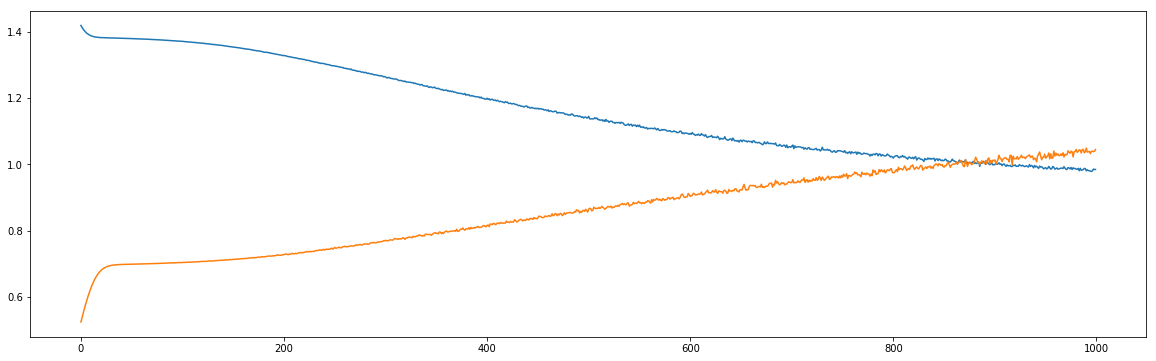

In [450]:
fig,ax = plt.subplots(figsize = (20,6))
ax.plot(d_errors)
ax.plot(g_errors)

In [274]:
plt.savefig('2800epochs_model1.png')

<Figure size 432x288 with 0 Axes>

In [281]:
torch.save(disc.state_dict(),'models/model1.pt')

In [284]:
m = torch.load('models/model1.pt')

In [287]:
m['hidden.0.bias']

tensor([-0.2178,  0.4005, -0.4102,  0.3267, -0.3745,  0.4669, -1.9859, -0.1809,
        -0.4065,  0.3878], device='cuda:0')

In [464]:
b = np.array(gen(noise(200)).detach().cpu())

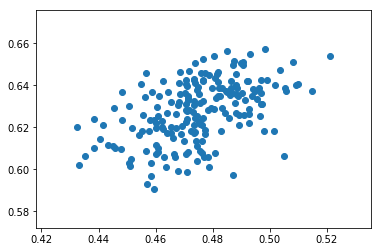

In [459]:
plt.scatter(b[:,0],b[:,1])
plt.show()

In [417]:
c = np.array(gen(noise(200)).detach().cpu())

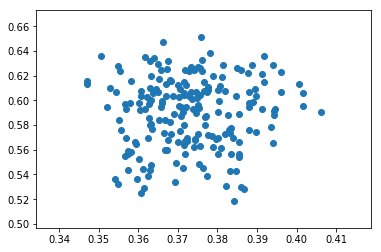

In [418]:
plt.scatter(c[:,0],c[:,1])
plt.show()

In [333]:
plt.savefig('1500_epoch_generator_data.png')

<Figure size 432x288 with 0 Axes>

In [325]:
d = np.array(gen(noise(200)).detach().cpu())

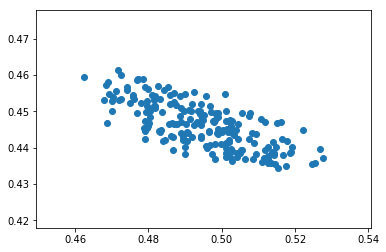

In [326]:
plt.scatter(d[:,0],d[:,1])

In [327]:
plt.savefig('3000_epoch_generator_data.png')

<Figure size 432x288 with 0 Axes>

In [465]:
pp = []
for i in range(200):
    pp.append(torch.load('data/'+ str(i+1) + '.pt'))

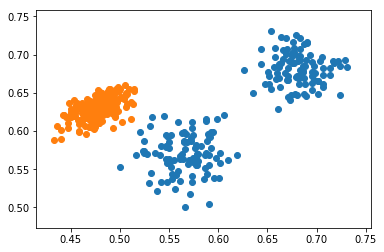

In [466]:
pp = [list(np.array(x)) for x in pp]
pp = torch.tensor(pp)
pp = torch.sigmoid(pp)
pp = np.array(pp.detach().cpu())
plt.scatter(pp[:,0],pp[:,1])
plt.scatter(b[:,0],b[:,1])

In [394]:
# torch.tensor(pp)